# hip2tex
ヒッパルコス星表のデータをいい感じに処理して、Shaderで表示するためのテクスチャに変換したい。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
hip = pd.read_table("BrowseTargets.13041.1545121565", sep="|", header=2, usecols=range(1, 7), skipinitialspace=True)
hip.head()

,name,parallax,vmag,ra_deg,dec_deg,bv_color
0,HIP 48752,4.17,7.84,149.167261,-89.782454,0.097
1,HIP 71348,2.08,6.82,218.878316,-89.771696,1.698
2,HIP 42708,2.39,7.20,130.518546,-89.460502,1.712
3,HIP 78866,11.95,7.83,241.481011,-89.308449,0.412
4,HIP 22645,4.42,8.86,73.084128,-89.273961,0.260


# 欠損値処理
各項目の欠損値の数

In [3]:
hip.isnull().sum()

name           0
parallax     263
vmag           1
ra_deg       263
dec_deg      263
bv_color    1281
dtype: int64

距離、方向が欠損したものは除去する。

In [4]:
hip = hip.dropna(subset=["parallax"])

bv_colorはなんか適当に埋めてみる。  
とりあえず中央値で埋める。

In [5]:
hip["bv_color"] = hip["bv_color"].fillna(hip["bv_color"].median())

# 座標変換
年周視差([parallax](https://heasarc.gsfc.nasa.gov/W3Browse/star-catalog/hipparcos.html#parallax)) $pi$と距離(parsec) $D$の関係は$D = 1000 / pi$。1 parsecは3.26光年。  
球座標系を直交座標系に変換する式はこんな感じになるはず。

$$
\begin{eqnarray}
x &=& \dfrac {1000}{P_{parallax}}\cos \theta_{dec} \cos \phi_{ra} \\
y &=& \dfrac {1000}{P_{parallax}}\cos \theta_{dec} \sin \phi_{ra} \\
z &=& \dfrac {1000}{P_{parallax}}\sin \theta_{dec}
\end{eqnarray}
$$

In [6]:
pos = np.empty((0, 3))

for index, i in hip.iterrows():
    if i["parallax"] != 0:
        x = 1000 / i["parallax"] * np.cos(np.deg2rad(i["dec_deg"])) * np.cos(np.deg2rad(i["ra_deg"]))
        y = 1000 / i["parallax"] * np.cos(np.deg2rad(i["dec_deg"])) * np.sin(np.deg2rad(i["ra_deg"]))
        z = 1000 / i["parallax"] * np.sin(np.deg2rad(i["dec_deg"]))
        pos = np.append(pos, np.array([[x, y, z]]), axis=0)

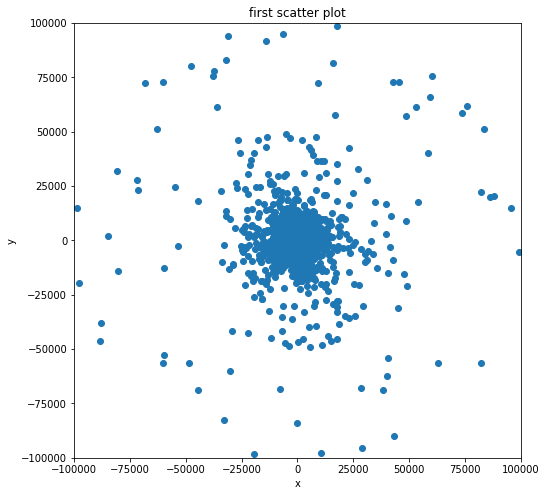

In [7]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(-100000,100000)
ax.set_ylim(-100000,100000)

ax.scatter(pos[0:,0], pos[0:,1])

ax.set_title('first scatter plot')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

# 絶対等級
[絶対等級](https://bit.ly/2A1RmtT)$M$は視等級$m$と年周視差$\pi$(秒)から計算できる。

$$
M=m-5\left( \log _{10} \pi +1\right)
$$

In [8]:
abs_mag = np.empty((0, 1))
for index, i in hip.iterrows():
    if i["parallax"] != 0:
        M = i["vmag"] - 5 * (np.log10(np.abs(i["parallax"])) / 1000 + 1)
        abs_mag = np.append(abs_mag, np.array([[M]]), axis=0)

In [9]:
hip.min()

name        HIP 1     
parallax        -54.95
vmag             -1.44
ra_deg      0.00091185
dec_deg       -89.7825
bv_color          -0.4
dtype: object